In [183]:
import numpy as np
import h5py
from scipy.interpolate import griddata
from matplotlib import pyplot as plt
 
# Define necessary functions and classes
def generateScatteringHoles(positions, rad, res=10):
    """Makes an array of dipole positions for a single scattering hole
    input:
        positions: position of each hole center
        rad: radius of the scattering hole
        res: number of dipoles to place along the scattering hole
    output:
        positions: (res x 3 np-array) 3d coordinates of the scattering hole dipoles
        normals: (res x 3 np-array) the unit vector normal to the surface of the scattering hole at each dipole location"""
    dipole_positions = []
    normals = []
    for hole_id in range(0, len(positions)):
        for i in range(0, res):
            normal_x = np.cos(i / res * 2 * np.pi)
            normal_y = np.sin(i / res * 2 * np.pi)
            x = normal_x * rad + positions[hole_id][0]
            y = normal_y * rad + positions[hole_id][1]
            dipole_positions.append([x, y, 0])
            normals.append([normal_x, normal_y, 0])
    return np.array(dipole_positions), np.array(normals)
 
def hexagonal_grid(n_rows, n_cols, align, spacing, hole_radius=0, hole_res=1):
    even_flag = False
    dipoles = []
    for i in range(-n_rows//2, n_rows//2+1):
        for j in range(-n_cols//2, n_cols//2+1):
            if even_flag:
                x_adjust = spacing / 2
            else:
                x_adjust = 0
            x_p = j * spacing + x_adjust - align[0]
            y_p = i * spacing * np.sqrt(3) / 2 - align[1]
            dipoles.append([x_p, y_p, 0])
        even_flag = not even_flag
    dipoles = np.array(dipoles)
    return dipoles

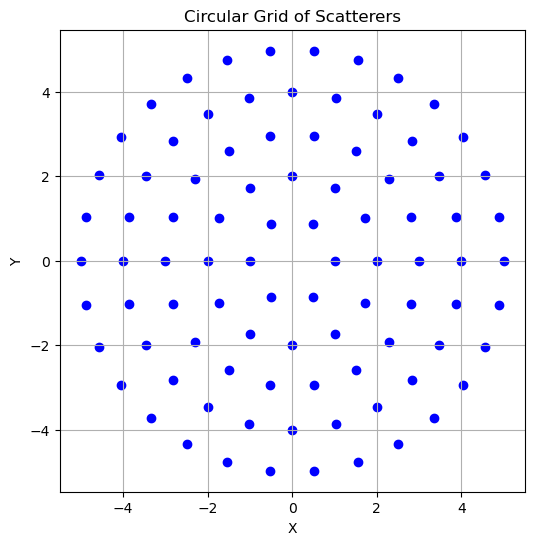

In [184]:
import numpy as np
import h5py
from scipy.interpolate import griddata
from matplotlib import pyplot as plt

# Define necessary functions and classes
def generateScatteringHoles(positions, rad, res=10):
    dipole_positions = []
    normals = []
    for hole_id in range(0, len(positions)):
        for i in range(0, res):
            normal_x = np.cos(i / res * 2 * np.pi)
            normal_y = np.sin(i / res * 2 * np.pi)
            x = normal_x * rad + positions[hole_id][0]
            y = normal_y * rad + positions[hole_id][1]
            dipole_positions.append([x, y, 0])
            normals.append([normal_x, normal_y, 0])
    return np.array(dipole_positions), np.array(normals)

def circular_grid(n_circles, points_per_circle, spacing, center=(0, 0)):
    dipoles = []
    for i in range(n_circles):
        # Calculate the radius for the current circle
        radius = spacing * (i + 1)
        # Calculate the number of points in this circle
        num_points = points_per_circle * (i + 1)
        for j in range(num_points):
            # Calculate angle for each point
            angle = j * (2 * np.pi / num_points)
            x_p = center[0] + radius * np.cos(angle)
            y_p = center[1] + radius * np.sin(angle)
            dipoles.append([x_p, y_p, 0])
    dipoles = np.array(dipoles)
    return dipoles

# Example usage
n_circles = 5  # Number of circles
points_per_circle = 6  # Base number of points per circle
spacing = 1.0  # Distance between circles
center = (0, 0)  # Center of the circular grid

# Generate circular grid
dipoles = circular_grid(n_circles, points_per_circle, spacing, center)

# Plotting the circular grid for visualization
plt.figure(figsize=(6, 6))
plt.scatter(dipoles[:, 0], dipoles[:, 1], marker='o', color='blue')
plt.title("Circular Grid of Scatterers")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid(True)
plt.show()


In [185]:
class Nearfield:
    def __init__(self, nearfield_E=None, x=None, y=None):
        self.E = nearfield_E
        self.x = x
        self.y = y
        if x is not None and y is not None:
            self.xx, self.yy = np.meshgrid(x, y)
   
    def __interpolate_E_intensities(self, intensity_grid, x_sample, y_sample, xx=None, yy=None, method='linear'):
        if xx is None:
            xx = self.xx
        if yy is None:
            yy = self.yy
        if intensity_grid is None:
            intensity_grid = self.E
        x_sample = x_sample.flatten()
        y_sample = y_sample.flatten()
        xx_flat = xx.flatten()
        yy_flat = yy.flatten()
        intensities_flat = intensity_grid.flatten()
        sample_locations = np.column_stack((x_sample.flatten(), y_sample.flatten()))
        interpolated_values = griddata((xx_flat, yy_flat), intensities_flat, sample_locations, method=method)
        return interpolated_values
 
    def __nearest_neighbor_E_intensities(self, intensity_grid, x_sample, y_sample, xx=None, yy=None):
        if xx is None:
            xx = self.xx
            yy = self.yy
            xx_flat = self.x
            yy_flat = self.y
        else:
            xx_flat = xx[0, :]
            yy_flat = yy[:, 0]
        if intensity_grid is None:
            intensity_grid = self.E
        sampled_intensities = np.zeros(len(x_sample))
        for i in range(0, len(x_sample)):
            nearest_x = np.argmin(np.abs(xx_flat - x_sample[i]))
            nearest_y = np.argmin(np.abs(yy_flat - y_sample[i]))
            sampled_intensities[i] = intensity_grid[nearest_y, nearest_x]
        return sampled_intensities

    def set_resolution_text(self, res, x_min=np.inf, x_max=np.inf, y_min=np.inf, y_max=np.inf):
        if x_min == np.inf:
            x_min = np.min(self.x)
        if x_max == np.inf:
            x_max = np.max(self.x)
        if y_min == np.inf:
            y_min = np.min(self.y)
        if y_max == np.inf:
            y_max = np.max(self.y)

        new_x = np.linspace(x_min, x_max, res)
        new_y = np.linspace(y_min, y_max, res)  # Fix: Use y_min instead of x_min
        new_xx, new_yy = np.meshgrid(new_x, new_y)

        new_grid_points = np.column_stack((new_xx.flatten(), new_yy.flatten()))
        new_x_points = new_grid_points[:,0]
        new_y_points = new_grid_points[:,1]

        if type(self.E[0,0,0]) != np.complex128:
            Ex = self.E[:,:,0]
            Ey = self.E[:,:,1]
            Ez = self.E[:,:,2]
            shape = np.shape(Ex)

            Ex = np.array([complex(a, b) for a, b in zip(np.real(Ex).ravel(), np.imag(Ex).ravel())]).reshape(Ex.shape)
            Ey = np.array([complex(a, b) for a, b in zip(np.real(Ey).ravel(), np.imag(Ey).ravel())]).reshape(Ey.shape)
            Ez = np.array([complex(a, b) for a, b in zip(np.real(Ez).ravel(), np.imag(Ez).ravel())]).reshape(Ez.shape)
        
        else:
            Ex = self.E[:,:,0]
            Ey = self.E[:,:,1]
            Ez = self.E[:,:,2]
            shape = np.shape(Ex)

        new_E = [[],[],[]]

        # Interpolate for Ex
        Ex_real_interpolated = self.__interpolate_E_intensities(np.real(Ex), new_x_points, new_y_points)
        Ex_imag_interpolated = self.__interpolate_E_intensities(np.imag(Ex), new_x_points, new_y_points)
        Ex_interpolated = Ex_real_interpolated + Ex_imag_interpolated * 1j

        # Interpolate for Ey
        Ey_real_interpolated = self.__interpolate_E_intensities(np.real(Ey), new_x_points, new_y_points)
        Ey_imag_interpolated = self.__interpolate_E_intensities(np.imag(Ey), new_x_points, new_y_points)
        Ey_interpolated = Ey_real_interpolated + Ey_imag_interpolated * 1j

        # Interpolate for Ez
        Ez_real_interpolated = self.__interpolate_E_intensities(np.real(Ez), new_x_points, new_y_points)
        Ez_imag_interpolated = self.__interpolate_E_intensities(np.imag(Ez), new_x_points, new_y_points)
        Ez_interpolated = Ez_real_interpolated + Ez_imag_interpolated * 1j

        new_E[0] = Ex_interpolated
        new_E[1] = Ey_interpolated
        new_E[2] = Ez_interpolated


        new_E = np.column_stack((new_E[0], new_E[1], new_E[2]))
        new_E = np.reshape(new_E, (res, res,3))

        self.E = new_E
        self.x = new_x
        self.y = new_y
        self.xx = new_xx
        self.yy = new_yy
 
    def set_resolution(self, res, x_min=np.inf, x_max=np.inf, y_min=np.inf, y_max=np.inf):
        if x_min == np.inf:
            x_min = np.min(self.x)
        if x_max == np.inf:
            x_max = np.max(self.x)
        if y_min == np.inf:
            y_min = np.min(self.y)
        if y_max == np.inf:
            y_max = np.max(self.y)
        new_x = np.linspace(x_min, x_max, res)
        new_y = np.linspace(x_min, y_max, res)
        new_xx, new_yy = np.meshgrid(new_x, new_y)
        new_grid_points = np.column_stack((new_xx.flatten(), new_yy.flatten()))
        new_x_points = new_grid_points[:, 0]
        new_y_points = new_grid_points[:, 1]
        if type(self.E[0, 0, 0]) != np.complex128:
            Ex = self.E[:, :, 0]
            Ey = self.E[:, :, 1]
            Ez = self.E[:, :, 2]
            shape = np.shape(Ex)
            Ex = np.array([a + b * 1j for a, b in np.ravel(Ex)])
            Ex = np.array([a +b*1j for a,b in zip(np.ravel(Ex.real), np.ravel(Ex.imag))])
            Ex = np.reshape(Ex, shape)
            Ey = np.array([a + b * 1j for a, b in np.ravel(Ey)])
            Ey = np.array([a +b*1j for a,b in zip(np.ravel(Ey.real), np.ravel(Ey.imag))])
            Ey = np.reshape(Ey, shape)
            Ez = np.array([a + b * 1j for a, b in np.ravel(Ez)])
            Ez = np.array([a +b*1j for a,b in zip(np.ravel(Ez.real), np.ravel(Ez.imag))])
            Ez = np.reshape(Ez, shape)
        else:
            Ex = self.E[:, :, 0]
            Ey = self.E[:, :, 1]
            Ez = self.E[:, :, 2]
            shape = np.shape(Ex)
        new_E = [[], [], []]
        Ex_real_interpolated = self.__interpolate_E_intensities(np.real(Ex), new_x_points, new_y_points)
        Ex_imag_interpolated = self.__interpolate_E_intensities(np.imag(Ex), new_x_points, new_y_points)
        Ex_interpolated = Ex_real_interpolated + Ex_imag_interpolated * 1j
        Ey_real_interpolated = self.__interpolate_E_intensities(np.real(Ey), new_x_points, new_y_points)
        Ey_imag_interpolated = self.__interpolate_E_intensities(np.imag(Ey), new_x_points, new_y_points)
        Ey_interpolated = Ey_real_interpolated + Ey_imag_interpolated * 1j
        Ez_real_interpolated = self.__interpolate_E_intensities(np.real(Ez), new_x_points, new_y_points)
        Ez_imag_interpolated = self.__interpolate_E_intensities(np.imag(Ez), new_x_points, new_y_points)
        Ez_interpolated = Ez_real_interpolated + Ez_imag_interpolated * 1j
        new_E[0] = Ex_interpolated
        new_E[1] = Ey_interpolated
        new_E[2] = Ez_interpolated
        new_E = np.column_stack((new_E[0], new_E[1], new_E[2]))
        new_E = np.reshape(new_E, (res, res, 3))
        self.E = new_E
        self.x = new_x
        self.y = new_y
        self.xx = new_xx
        self.yy = new_yy
 
    def sample_E(self, positions, projection_vector=None, neglect_Ez=False, sampling_method="interpolate", poynting_grid=None):
        x_points = positions[:, 0]
        y_points = positions[:, 1]
        # Check the dimensionality of self.E
        if len(self.E.shape) == 3:
            Ex = self.E[:, :, 0]
            Ey = self.E[:, :, 1]
            Ez = self.E[:, :, 2]
        elif len(self.E.shape) == 2:
            Ex = self.E[:, 0]
            Ey = self.E[:, 1]
            Ez = self.E[:, 2]
 
        else:
            raise ValueError("Unsupported dimensionality of self.E")
        if type(self.E[0, 0,0]) != np.complex128:
            Ex = self.E[:, :, 0]
            Ey = self.E[:, :, 1]
            Ez = self.E[:, :, 2]
            shape = np.shape(Ex)
            Ex = np.array([a + b * 1j for a, b in np.ravel(Ex)])
            Ex = np.array([a +b*1j for a,b in zip(np.ravel(Ex.real), np.ravel(Ex.imag))])
            Ex = np.reshape(Ex, shape)
            Ey = np.array([a + b * 1j for a, b in np.ravel(Ey)])
            Ey = np.array([a +b*1j for a,b in zip(np.ravel(Ey.real), np.ravel(Ey.imag))])
            Ey = np.reshape(Ey, shape)
            Ez = np.array([a + b * 1j for a, b in np.ravel(Ez)])
            Ez = np.array([a +b*1j for a,b in zip(np.ravel(Ez.real), np.ravel(Ez.imag))])
            if neglect_Ez:
                Ez = np.zeros(np.shape(Ez))
                Ez = np.reshape(Ez, shape)
        else:
            Ex = self.E[:, :, 0]
            Ey = self.E[:, :, 1]
            Ez = self.E[:, :, 2]
            shape = np.shape(Ex)
            if neglect_Ez:
                Ez = np.zeros(np.shape(Ez))
                Ez = np.reshape(Ez, shape)
 
        points_E_intensity = [[], [], []]
 
        if sampling_method == "interpolate":
            Ex_real_interpolated = self.__interpolate_E_intensities(np.real(Ex), x_points, y_points)
            Ex_imag_interpolated = self.__interpolate_E_intensities(np.imag(Ex), x_points, y_points)
            Ex_interpolated = Ex_real_interpolated + Ex_imag_interpolated * 1j
 
 
            Ey_real_interpolated = self.__interpolate_E_intensities(np.real(Ey), x_points, y_points)
            Ey_imag_interpolated = self.__interpolate_E_intensities(np.imag(Ey), x_points, y_points)
            Ey_interpolated = Ey_real_interpolated + Ey_imag_interpolated * 1j
 
            Ez_real_interpolated = self.__interpolate_E_intensities(np.real(Ez), x_points, y_points)
            Ez_imag_interpolated = self.__interpolate_E_intensities(np.imag(Ez), x_points, y_points)
            Ez_interpolated = Ez_real_interpolated + Ez_imag_interpolated * 1j
 
            points_E_intensity[0] = Ex_interpolated
            points_E_intensity[1] = Ey_interpolated
            points_E_intensity[2] = Ez_interpolated
        elif sampling_method == "nearest_neighbor":
            Ex_neighbors = self.__nearest_neighbor_E_intensities(np.real(Ex), x_points, y_points) + self.__nearest_neighbor_E_intensities(np.imag(Ex), x_points, y_points) * 1j
            Ey_neighbors = self.__nearest_neighbor_E_intensities(np.real(Ey), x_points, y_points) + self.__nearest_neighbor_E_intensities(np.imag(Ey), x_points, y_points) * 1j
            Ez_neighbors = self.__nearest_neighbor_E_intensities(np.real(Ez), x_points, y_points) + self.__nearest_neighbor_E_intensities(np.imag(Ez), x_points, y_points) * 1j
            points_E_intensity[0] = Ex_neighbors
            points_E_intensity[1] = Ey_neighbors
            points_E_intensity[2] = Ez_neighbors
 
        if projection_vector is not None:
            points_E_intensity = np.dot(points_E_intensity, np.transpose(projection_vector))
 
        return points_E_intensity
 
 
   
 
        if projection_vector is not None:
            points_E_intensity = np.dot(points_E_intensity, np.transpose(projection_vector))
 
        return points_E_intensity
   
   
   
    def get_E(self):
        return self.E
 
    def set_E(self, E):
        self.E = E
# The load_nearfield function is such a standalone function. It's defined outside of the class, which is why
# it is not indented like the methods within the Nearfield class.
def load_nearfield(file_name, grid_id='E', x_id='x', y_id='y'):
    """Imports the electric field data from a .mat file. Data may not be linearly spaced along the x and y axes
    input:
        file_name: (str) name of the .mat file to import
    output:
        E_grid: (n x m x 3 np-array) 3d electric field grid. Each pixel contains the real and complex part of the x, y, and z electric field component.
        x: (n x 1 np-array) x positions of the field data
        y: (n x 1 np-array) y positions of the field data"""
    f = h5py.File(file_name, 'r')
    E_grid = np.array(f[grid_id])
    x = f[x_id]
    y = f[y_id]
    E_grid = np.swapaxes(E_grid, 0, 2)
    E_grid = np.swapaxes(E_grid, 0, 1)
   
    return Nearfield(E_grid, x, y)

def load_nearfield_text(file_path, format_type = 'grid'):

    with open(file_path, 'r') as f:
        lines = f.readlines()

    if format_type == 'grid':
        E_data = np.array([list(map(float, line.split())) for line in lines[1:] if line.strip()]) 

        n,m = E_data.shape
        x_data = np.linspace(-1.5e-6, 1.5e-6, n) 
        y_data = np.linspace(-1.5e-6, 1.5e-6, m)
    
    elif format_type == "metadata":

        x_start_idx = next(i for i, line in enumerate(lines) if 'x(m)' in line) + 1
        x_data = np.array([float(line.strip()) for line in lines[x_start_idx:] if line.strip() and not any(c.isalpha() for c in line)])

        y_start_idx = next(i for i, line in enumerate(lines) if 'y(m)' in line) + 1
        y_data = np.array([float(line.strip()) for line in lines[y_start_idx:] if line.strip() and not any(c.isalpha() for c in line)])

        E_start_idx = y_start_idx + len(y_data)

        E_data = np.array([list(map(float, line.split())) for line in lines[E_start_idx:] if line.strip()])

    else:
        raise ValueError("Invalid format_type. Use 'grid' for Nearfiled or 'metadata' for NF.")

    # Convert to (n, m, 3) shape (expanding last axis)
    E_grid = np.expand_dims(E_data, axis=-1)  # Convert to (n, m, 1)
    E_grid = np.repeat(E_grid, 3, axis=-1)  # Expand to (n, m, 3)

    return Nearfield(E_grid, x_data, y_data)


In [186]:
class DipoleSimulation_intermediate:
    def __init__(self, background_index=1.4, theta_lim=np.pi/2, res=70, intermediate_distance=2.5e-6):
        self.background_index = background_index
        self.theta_res = res
        self.phi_res = int(2 * np.pi * self.theta_res / theta_lim)
        t = np.linspace(0, theta_lim, self.theta_res)
        p = np.linspace(0, 2 * np.pi, self.phi_res)
        self.theta, self.phi = np.meshgrid(t, p)
 
        self.x = intermediate_distance * np.sin(self.theta) * np.cos(self.phi)
        self.y = intermediate_distance * np.sin(self.theta) * np.sin(self.phi)
        self.z = intermediate_distance * np.cos(self.theta)
 
       
        self.x_if = (intermediate_distance)  * np.tan(self.theta) * np.cos(self.phi)
        self.y_if = (intermediate_distance)  * np.tan(self.theta) * np.sin(self.phi)
        self.z_if = (intermediate_distance ) * np.ones_like(self.x_if)
 
        self.x_if = (intermediate_distance ) * np.sin(self.theta) * np.cos(self.phi)
        self.y_if = (intermediate_distance ) * np.sin(self.theta) * np.sin(self.phi)
        self.z_if = (intermediate_distance ) * np.cos(self.theta)
 
       
 
 
        self.nearfields = {}
        self.scatterers = []
       
        self.intermediate_points = np.array([[self.x[i, j], self.y[i, j], self.z[i, j]] for i in range(self.phi_res) for j in range(self.theta_res)])
        self.intermediate_points_if = np.array([[self.x_if[i, j], self.y_if[i, j], self.z_if[i,j]] for i in range(self.phi_res) for j in range(self.theta_res)])
       
        print(f"E2 shape: {self.x_if.shape}")
    def __validate_simulation(self):
        return len(self.scatterers) > 0 and len(self.nearfields) > 0
 
    def get_intermediate_field(self, wavelength, nearfield_id=0, neglect_Ez=True, sampling_method="nearest_neighbor", return_components=False):
        """Calculates the intermediate field pattern of a set of dipoles
        input:
            wavelength: (float) wavelength in meters
            nearfield_id: (int) the id of the nearfield to use for the intermediate field calculation
            neglect_Ez: (bool) set the z component of the electric field to 0
        output:
            E_2: (n x n np-array) far field pattern of the dipoles"""
        if self.__validate_simulation():
            k = 2 * self.background_index * np.pi / wavelength
            if isinstance(nearfield_id, int):
                nearfield_id = list(self.nearfields.keys())[nearfield_id]
            dipoles = [scatterer.get_dipoles() for scatterer in self.scatterers]
            dipole_positions, dipole_normals = [item for item in zip(*dipoles)]
            dipole_positions = np.squeeze(np.array(dipole_positions))
            dipole_normals = np.squeeze(np.array(dipole_normals))
 
 
 
            # reading nearfield data
            E = self.nearfields[nearfield_id].sample_E(dipole_positions, neglect_Ez=neglect_Ez, sampling_method=sampling_method)
           
            if E is None:
                raise ValueError("The sample_E function returned None. Please check the implementation.")
            # This reshapes the nearfield array E[0], E[1] and E[2] into a 2D array with len(dipole_positions) rows and 1 column.
            Ex = np.reshape(E[0], (len(dipole_positions), 1))
            Ey = np.reshape(E[1], (len(dipole_positions), 1))
            Ez = np.reshape(E[2], (len(dipole_positions), 1))
           
           
            # Eculidean norm between nearfield points and dipoles at intermediate field points along axis=2
            # which is the 3 corresponding to the 3D vectors' components
            rad = np.linalg.norm(dipole_positions[:, np.newaxis] - self.intermediate_points[np.newaxis, :], axis=2)
            rad_if = np.linalg.norm(dipole_positions[:, np.newaxis] - self.intermediate_points_if[np.newaxis, :], axis=2) # Calculate the distance between the dipoles and the intermediate field points on the mapping sphere.
 
 
     

            exponentials = np.exp(-1j * k * rad) / rad**2
            
            exponentials_if = np.exp(-1j * k * rad_if) / rad_if**2
 
            t_flat = self.theta.flatten()
            p_flat = self.phi.flatten()
 
            E_theta = np.sum((exponentials) * (Ex * np.cos(t_flat) * np.cos(p_flat) + Ey * np.cos(t_flat) * np.sin(p_flat) - Ez * np.sin(t_flat)), axis=0)
            E_phi = np.sum((exponentials) * (-Ex * np.sin(p_flat) + Ey * np.cos(p_flat)), axis=0)
            E_r = np.sum((exponentials) *  (Ex * np.sin(t_flat) * np.cos(p_flat) + Ey * np.sin(t_flat) * np.sin(p_flat) + Ez * np.cos(t_flat)), axis=0)
 
            # Electric field components on mapping sphere
            E_theta_if = np.sum(exponentials_if * (Ex * np.cos(t_flat) * np.cos(p_flat) + Ey * np.cos(t_flat) * np.sin(p_flat) - Ez * np.sin(t_flat)), axis=0)
            E_phi_if = np.sum(exponentials_if * (-Ex * np.sin(p_flat) + Ey * np.cos(p_flat)), axis=0)
            E_r_if = np.sum(exponentials_if * (Ex * np.sin(t_flat) * np.cos(p_flat) + Ey * np.sin(t_flat) * np.sin(p_flat) + Ez * np.cos(t_flat)), axis=0)
           
           
 
            # Electric field components on mapping sphere
            Ex_if = -E_phi_if*np.sin(p_flat) + E_theta_if*np.cos(p_flat)*np.cos(t_flat) + E_r_if*np.sin(t_flat)*np.cos(p_flat)
            Ey_if = E_phi_if*np.cos(p_flat) + E_theta_if*np.sin(p_flat)*np.cos(t_flat) + E_r_if*np.sin(t_flat)*np.sin(p_flat)
            Ez_if = -E_theta_if*np.sin(t_flat) + E_r_if*np.cos(t_flat)
 
 
 
 
            Ex_if = np.reshape(Ex_if, (self.phi_res, self.theta_res))
            Ey_if = np.reshape(Ey_if, (self.phi_res, self.theta_res))
            Ez_if = np.reshape(Ez_if, (self.phi_res, self.theta_res))
 
           
 
            self.saved_wavelength = wavelength
            self.E_2 = np.abs(E_theta)**2 + np.abs(E_phi)**2 + 0*np.abs(E_r)**2
            self.E_2 = np.reshape(self.E_2, (self.phi_res, self.theta_res))
 
 
            #self.E_2 = np.abs(E_theta_if)**2 + np.abs(E_phi_if)**2
            #self.E_2 = np.reshape(self.E_2, (self.phi_res, self.theta_res))
 
 
       
 
                       # Print shapes
            print(f"E2 shape: {self.E_2.shape}")          
            print(f"Ex_if shape: {Ex_if.shape}")
            print(f"Ey_if shape: {Ey_if.shape}")
            print(f"Ez_if shape: {Ez_if.shape}")
            print(f"x shape: {self.x.shape}")
            print(f"y shape: {self.y.shape}")
            print(f"x_if shape: {self.x_if.shape}")
        if return_components:
           return self.E_2, Ex_if, Ey_if, Ez_if
        else:
            return self.E_2
   
    def get_efficiency_by_theta(self, wavelength, use_saved_E=True, gain=1):
        if self.__validate_simulation():
            if self.saved_wavelength == wavelength and use_saved_E:
                E_2 = self.E_2
            else:
                E_2 = self.get_intermediate_field(wavelength)
            adjusted_E_2 = E_2 * np.sin(self.theta)
            total_power = np.sum(adjusted_E_2)
            power = np.sum(adjusted_E_2, axis=0)
            power /= total_power
            efficiency = np.cumsum(power)
            return efficiency * gain
        return None
    def add_scatterers(self, scatterers):
        self.scatterers = self.scatterers + scatterers
 
    def add_nearfield(self, nearfield: Nearfield, nearfield_id):
        self.nearfields[nearfield_id] = nearfield # adds or updates a near-field object in the self.nearfields dictionary of the class instance.

In [187]:
class Scatterer:
    def __init__(self):
        pass
    def get_dipoles(self, res):
        pass
    def get_nearfield_perurbation(self, nearfield):
        pass
 

In [188]:
class ScatteringCircle(Scatterer):
    def __init__(self, center, radius=0, res=1):
        self.radius = radius
        self.center = center
        self.res = res
 
    def get_relevant_area(self, xx, yy):
        return np.argwhere((xx - self.center[0])**2 + (yy - self.center[1])**2 <= self.radius**2)
        """ Returns the indices of xx and yy that are within the scattering circle
        input:
            xx: (n x m np-array) x positions of the field data
            yy: (n x m np-array) y positions of the field data
        """
    def get_dipoles(self):
        """ Makes an array of dipole positions for the scattering circle
        output:
            positions: (res x 3 np-array) 3d coordinates of the scattering circle dipoles
            normals: (res x 3 np-array) the unit vector normal to the surface of the scattering circle at each dipole location
        """
        dipole_positions = []
        normals = []
        for i in range(0, self.res):
            normal_x = np.cos(i / self.res * 2 * np.pi)
            normal_y = np.sin(i / self.res * 2 * np.pi)
            x = normal_x * self.radius + self.center
            y = normal_y * self.radius + self.center
            dipole_positions.append([x, y, 0])
            normals.append([normal_x, normal_y, 0])
        return np.array(dipole_positions), np.array(normals)
 
    def get_nearfield_perurbation(self, nearfield):
        perturbation = Nearfield(np.zeros(np.shape(nearfield.E)), x=nearfield.x, y=nearfield.y)
        relevant_E = nearfield.E[self.get_relevant_area(nearfield.xx, nearfield.yy)]
        return perturbation

In [189]:
class ScatteringPoint:
    """Location of dipoles are determiend by the center of the scattering point
    The orientation of the dipoles is equal in all directions
    the Calculates and returns a perturbation in the near-field, represented by a Nearfield object initialized with zeros.
    This perturbation is associated with the scattering point's influence on the electromagnetic field."""
    def __init__(self, center):
        self.center = center
    def get_dipoles(self):
        x = self.center[0]
        y = self.center[1]
        return np.array([[x, y, 0]]), np.array([[1, 1, 1]]) # The unit vector in dipole poosition. The  dipole's orientation is [1,1,1]]
    def get_nearfield_perurbation(self, nearfield):       #  perturbation in the near-field due to the scattering point.
        perturbation = Nearfield(np.zeros(np.shape(nearfield.E)), x=nearfield.x, y=nearfield.y)
        return perturbation          

E2 shape: (280, 70)
E2 shape: (280, 70)
Ex_if shape: (280, 70)
Ey_if shape: (280, 70)
Ez_if shape: (280, 70)
x shape: (280, 70)
y shape: (280, 70)
x_if shape: (280, 70)


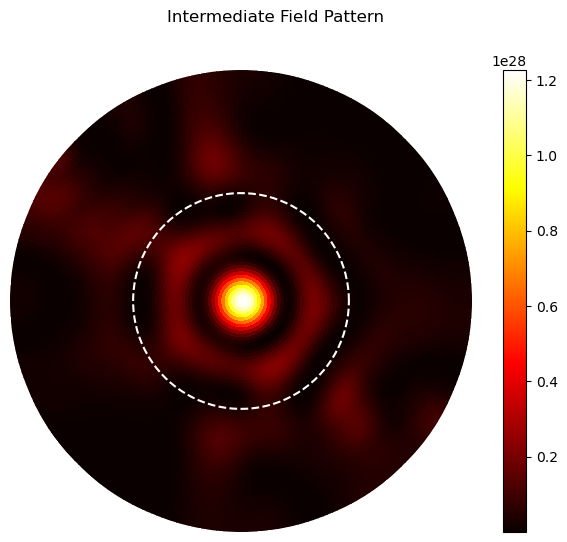

In [193]:
# Define additional functions for plotting
def plotintermediate_field_2D(magnitudes_squared, phi=None, theta=None, ring30=False, ring70=False, save_file=None):
    if phi is None:
        phi = globals()['phi']
    if theta is None:
        theta = globals()['theta']
   
    fig = plt.figure(figsize=(8, 6))
    plt.suptitle(f"Intermediate Field Pattern")
    ax3 = fig.add_subplot(1, 1, 1, polar=True)
 
    im3 = ax3.pcolormesh(phi, theta, magnitudes_squared, cmap="hot")
    fig.colorbar(im3, ax=ax3)
    ax3.grid(False)
    ax3.axis('off')
 
    if ring30:
        ax3.plot(np.linspace(0, 2*np.pi, 100), 1.4*np.ones(100) * np.pi/6, color='w', linestyle='--')
    if ring70:
        ax3.plot(np.linspace(0, 2*np.pi, 100), 1.4*np.ones(100) * np.pi*7/18, color='w', linestyle='--')
   
    if save_file:
        plt.savefig(save_file)
    plt.show()
 
def plot_near_field(E_grid, x, y, res=200, x_min=np.inf, x_max=np.inf, y_min=np.inf, y_max=np.inf, cmap='viridis', save_file=None):
    if x_min == np.inf:
        x_min = np.min(x)
    if x_max == np.inf:
        x_max = np.max(x)
    if y_min == np.inf:
        y_min = np.min(y)
    if y_max == np.inf:
        y_max = np.max(y)
   
    monitor_x_sample = np.linspace(x_min, x_max, res)
    monitor_y_sample = np.linspace(x_min, y_max, res)
    monitor_xx_sample, monitor_yy_sample = np.meshgrid(monitor_x_sample, monitor_y_sample)
 
    monitor_points = np.column_stack((monitor_xx_sample.flatten(), monitor_yy_sample.flatten()))
    monitor_E = nearfield.sample_E(monitor_points, neglect_Ez=False, sampling_method="interpolate")
    monitor_E = np.reshape(monitor_E[:, :], (res, res, 3))
 
    monitor_E2 = np.abs(monitor_E[:, :, 0])**2 + np.abs(monitor_E[:, :, 1])**2 + np.abs(monitor_E[:, :, 2])**2
 
    plt.figure(figsize=(8, 6))
    plt.imshow(monitor_E2[:, :], cmap=cmap, extent=[x_min, x_max, y_min, y_max])
    plt.title('Monitor E2')
    plt.xlabel('x (um)')
    plt.ylabel('y (um)')
    plt.colorbar()
    if save_file:
        plt.savefig(save_file)
    plt.show()
 
# Define the parameters of the simulation
wavelength = 0.637e-6  # frequency of light
n = 1.4  # index of refraction
 
# Hexagonal Grid Structure
n_rows = 10
n_cols = 10
spacing = 0.335e-6
align = np.array([.5*spacing/2, 0, 0])
scattering_centers = hexagonal_grid(n_rows, n_cols, align, spacing)
 

n_circles = 10  # Number of circles
points_per_circle = 6  # Base number of points per circle
spacing = 0.335e-6  # Distance between circles
center = (0, 0)  # Center of the circular grid

# Generate circular grid
#dipoles = circular_grid(n_circles, points_per_circle, spacing, center)
# Instantiate the simulation by excuting the class DipoleSimulation_intermediate
sim = DipoleSimulation_intermediate(background_index=1.4, intermediate_distance=2.5e-6)
 
# Create and add the nearfield
nearfield = load_nearfield_text(file_path='matfiles/Nearfield_full')
nearfield.set_resolution_text(101)
sim.add_nearfield(nearfield, "control_nearfield")
 
scatterers = [ScatteringPoint(pos) for pos in scattering_centers]
 
# Create and add the dipole grid
sim.add_scatterers(scatterers)
#Intermediate_field = self.E_2
intermediate_field, Ex_if, Ey_if, Ez_if = sim.get_intermediate_field(wavelength=wavelength, neglect_Ez=True, sampling_method="nearest_neighbor", return_components=True)
#Run the simulation and plot the intermediate field (formerly intermediate_field)
#intermediate_field = sim.get_intermediate_field(wavelength=wavelength, neglect_Ez=True, sampling_method="nearest_neighbor")
plotintermediate_field_2D(intermediate_field, theta=sim.theta, phi=sim.phi, ring30=True, ring70=False, save_file="test_intermediate_field")
 

In [ ]:
import numpy as np
import h5py
from scipy.interpolate import griddata
from matplotlib import pyplot as plt
 
# Define necessary functions and classes
def generateScatteringHoles_if(positions, rad_if, res=10, intermediate_distance=2.5e-6 ):
    dipole_positions_if = []
    normals = []
    for hole_id in range(0, len(positions)):
        for i in range(0, res):
            normal_x = np.cos(i / res * 2 * np.pi)
            normal_y = np.sin(i / res * 2 * np.pi)
            x = normal_x * rad_if + positions[hole_id][0]
            y = normal_y * rad_if + positions[hole_id][1]
            dipole_positions_if.append([x, y, intermediate_distance])
            normals.append([normal_x, normal_y, 0])
    return np.array(dipole_positions_if), np.array(normals)

In [ ]:
def hexagonal_grid_if(n_rows, n_cols, align_if, spacing_if, intermediate_distance, hole_radius=0, hole_res=1):
    """
    Generates a hexagonal grid of dipoles and places them on a 2D plane or at a fixed intermediate_distance.
   
    Parameters:
    - n_rows, n_cols: Number of rows and columns of the hexagonal grid
    - align: Alignment vector for the grid
    - spacing_if: Spacing between the dipoles in the grid
    - intermediate_distance: The distance at which to place the dipoles (in the z-direction)
    - hole_radius, hole_res: Parameters for scattering holes (if needed)
   
    Returns:
    - dipoles_if: A numpy array of 3D dipole positions at the intermediate distance
    """
    even_flag = False
    dipoles_if = []
   
    for i in range(-n_rows//2, n_rows//2+1):
        for j in range(-n_cols//2, n_cols//2+1):
            if even_flag:
                x_adjust = spacing_if / 2
            else:
                x_adjust = 0
            x_p = j * spacing_if + x_adjust - align_if[0]
            y_p = i * spacing_if * np.sqrt(3) / 2 - align_if[1]
           
            # Place dipole at the correct intermediate radius (z = intermediate_distance)
            dipole_position_if = [x_p, y_p, intermediate_distance]  # x, y, and z = intermediate_distance
            dipoles_if.append(dipole_position_if)
       
        even_flag = not even_flag
   
    dipoles_if = np.array(dipoles_if)
    return dipoles_if

In [ ]:
import numpy as np
from scipy.interpolate import griddata
 
class IntermediateField:
    def __init__(self, Ex_if, Ey_if, Ez_if, x_if, y_if):
        """
        Initializes the IntermediateField class with the provided electric field components
        and the grid points in the intermediate plane.
        input:
            Ex_if: (n x m np-array) x-component of the electric field on the intermediate plane.
            Ey_if: (n x m np-array) y-component of the electric field on the intermediate plane.
            Ez_if: (n x m np-array) z-component of the electric field on the intermediate plane.
            x_if: (n x m np-array) x-coordinates of the grid points on the intermediate plane.
            y_if: (n x m np-array) y-coordinates of the grid points on the intermediate plane.
        """
        self.Ex_if = Ex_if
        self.Ey_if = Ey_if
        self.Ez_if = Ez_if
        self.E = np.stack([self.Ex_if, self.Ey_if, self.Ez_if], axis=-1)  # Combine into a single array
 
        self.x = x_if
        self.y = y_if
        if x_if is not None and y_if is not None:
            self.xx, self.yy = np.meshgrid(x_if, y_if)
   
    def __interpolate_E_intensities(self, intensity_grid, x_sample, y_sample, xx=None, yy=None, method='linear'):
        """
        Interpolates electric field intensities at the given sample locations using griddata.
        input:
            intensity_grid: (n x m np-array) Grid of the electric field component to be interpolated.
            x_sample: (array) x-coordinates where interpolation is needed.
            y_sample: (array) y-coordinates where interpolation is needed.
            xx: (n x m np-array) x-coordinates of the grid points (optional).
            yy: (n x m np-array) y-coordinates of the grid points (optional).
            method: (str) Interpolation method ('linear' by default).
        output:
            Interpolated electric field intensities at the sample locations.
        """
        if xx is None:
            xx = self.xx
        if yy is None:
            yy = self.yy
        if intensity_grid is None:
            intensity_grid = self.E
       
        # Flatten the grid and sample points for interpolation
        xx_flat = xx.flatten()
        yy_flat = yy.flatten()
        intensities_flat = intensity_grid.flatten()
        sample_locations = np.column_stack((x_sample.flatten(), y_sample.flatten()))
       
        # Perform interpolation using the specified method
        interpolated_values = griddata((xx_flat, yy_flat), intensities_flat, sample_locations, method=method)
        return interpolated_values
 
    def __nearest_neighbor_E_intensities(self, intensity_grid, x_sample, y_sample, xx=None, yy=None):
        """
        Uses nearest neighbor interpolation for electric field intensities at the given sample locations.
        input:
            intensity_grid: (n x m np-array) Grid of the electric field component to be interpolated.
            x_sample: (array) x-coordinates where interpolation is needed.
            y_sample: (array) y-coordinates where interpolation is needed.
            xx: (n x m np-array) x-coordinates of the grid points (optional).
            yy: (n x m np-array) y-coordinates of the grid points (optional).
        output:
            Interpolated electric field intensities using nearest neighbor method.
        """
        if xx is None:
            xx = self.xx
            yy = self.yy
        else:
            xx_flat = xx[0, :]
            yy_flat = yy[:, 0]
 
        xx_flat = xx.flatten()
        yy_flat = yy.flatten()
        sampled_intensities = np.zeros(len(x_sample))
        for i in range(len(x_sample)):
            nearest_x = np.argmin(np.abs(xx_flat - x_sample[i]))
            nearest_y = np.argmin(np.abs(yy_flat - y_sample[i]))
            sampled_intensities[i] = intensity_grid[nearest_y, nearest_x]
        return sampled_intensities
 
    def set_resolution(self, res, x_min=np.inf, x_max=np.inf, y_min=np.inf, y_max=np.inf):
        """
        Changes the resolution of the grid by interpolating the data to the new grid points.
        input:
            res: (int) Resolution of the grid.
            x_min: (float) Minimum x value of the grid (optional).
            x_max: (float) Maximum x value of the grid (optional).
            y_min: (float) Minimum y value of the grid (optional).
            y_max: (float) Maximum y value of the grid (optional).
        """
        if x_min == np.inf:
            x_min = np.min(self.x)
        if x_max == np.inf:
            x_max = np.max(self.x)
        if y_min == np.inf:
            y_min = np.min(self.y)
        if y_max == np.inf:
            y_max = np.max(self.y)
       
        new_x = np.linspace(x_min, x_max, res)
        new_y = np.linspace(y_min, y_max, res)
        new_xx, new_yy = np.meshgrid(new_x, new_y)
       
        new_Ex = self.__interpolate_E_intensities(np.real(self.Ex_if), new_xx, new_yy) + \
                 1j * self.__interpolate_E_intensities(np.imag(self.Ex_if), new_xx, new_yy)
       
        new_Ey = self.__interpolate_E_intensities(np.real(self.Ey_if), new_xx, new_yy) + \
                 1j * self.__interpolate_E_intensities(np.imag(self.Ey_if), new_xx, new_yy)
       
        new_Ez = self.__interpolate_E_intensities(np.real(self.Ez_if), new_xx, new_yy) + \
                 1j * self.__interpolate_E_intensities(np.imag(self.Ez_if), new_xx, new_yy)
 
        # Combine into a new field array
        self.E = np.stack([new_Ex, new_Ey, new_Ez], axis=-1)
        self.x = new_x
        self.y = new_y
        self.xx = new_xx
        self.yy = new_yy
 
    def sample_E(self, positions_if, projection_vector=None, neglect_Ez=False, sampling_method="interpolate"):
        """
        Samples the electric field at the given positions.
        input:
            positions: (n x 2 np-array) Coordinates where the electric field needs to be sampled.
            projection_vector: (n x 3 np-array) Vector to project the electric field onto (optional).
            neglect_Ez: (bool) If True, the z component of the electric field will be set to zero.
            sampling_method: (str) Method to use for sampling the field data ('interpolate' or 'nearest_neighbor').
        output:
            Sampled electric field intensities at the specified positions.
        """
        x_points = positions_if[:, 0]
        y_points = positions_if[:, 1]
 
        if len(self.E.shape) == 3:
            Ex = self.E[:, :, 0]
            Ey = self.E[:, :, 1]
            Ez = self.E[:, :, 2]
        else:
            raise ValueError("Unsupported dimensionality of self.E")
 
        if sampling_method == "interpolate":
            Ex_sampled = self.__interpolate_E_intensities(Ex, x_points, y_points)
            Ey_sampled = self.__interpolate_E_intensities(Ey, x_points, y_points)
            Ez_sampled = self.__interpolate_E_intensities(Ez, x_points, y_points)
        elif sampling_method == "nearest_neighbor":
            Ex_sampled = self.__nearest_neighbor_E_intensities(Ex, x_points, y_points)
            Ey_sampled = self.__nearest_neighbor_E_intensities(Ey, x_points, y_points)
            Ez_sampled = self.__nearest_neighbor_E_intensities(Ez, x_points, y_points)
        else:
            raise ValueError("Unsupported sampling method")
 
        if neglect_Ez:
            Ez_sampled = np.zeros_like(Ex_sampled)
 
        sampled_E = np.column_stack((Ex_sampled, Ey_sampled, Ez_sampled))
 
        if projection_vector is not None:
            sampled_E = np.dot(sampled_E, projection_vector.T)
 
        return sampled_E
 
    def get_E(self):
        """Returns the combined electric field components."""
        return self.E
 
    def set_E(self, E):
        """Sets the electric field components."""
        self.E = E

In [ ]:
class DipoleSimulation_farfield:
    def __init__(self, background_index=1.4, theta_lim=np.pi/2, res=70, intermediate_distance=2.5e-6, far_distance=.1):
        self.background_index = background_index
        self.theta_res = res
        self.phi_res = int(2 * np.pi * self.theta_res / theta_lim)
        t = np.linspace(0, theta_lim, self.theta_res)
        p = np.linspace(0, 2 * np.pi, self.phi_res)
        self.theta, self.phi = np.meshgrid(t, p)
        self.x = (far_distance) * np.sin(self.theta) * np.cos(self.phi)
        self.y = (far_distance) * np.sin(self.theta) * np.sin(self.phi)
        self.z = (far_distance) * np.cos(self.theta)
        self.scatterers_if = []
        self.far_points = np.array([[self.x[i, j], self.y[i, j], self.z[i, j]] for i in range(self.phi_res) for j in range(self.theta_res)])
 
    def __validate_simulation(self):
        return len(self.scatterers_if) > 0
 
    def add_scatterers_if(self, scatterers_if):
        """
        This method adds the intermediate dipole scatterers (located at the intermediate radius)
        into the far-field simulation.
        """
        self.scatterers_if.extend(scatterers_if)  # Append scatterers to the current list of scatterers
 
    def get_farfield(self, wavelength, Ex_if, Ey_if, Ez_if, neglect_Ez=True):
        if self.__validate_simulation():
            k = 2 * self.background_index * np.pi / wavelength
 
            # Get the dipole positions from the scatterers
            dipoles_if = [scatterer.get_dipoles_if() for scatterer in self.scatterers_if]
            dipole_positions_if, dipole_normals = [item for item in zip(*dipoles_if)]
            dipole_positions_if = np.squeeze(np.array(dipole_positions_if))
            dipole_normals = np.squeeze(np.array(dipole_normals))
 
            # Calculate the distance between each dipole and each far-field point
            rad_ff = np.linalg.norm(dipole_positions_if[:, np.newaxis] - self.far_points[np.newaxis, :], axis=2)
            exponentials = np.exp(-1j * k * rad_ff)/rad_ff
 
            # Flatten theta and phi arrays
            t_flat = self.theta.flatten()
            p_flat = self.phi.flatten()
 
            # Calculate the far-field components using the provided intermediate field components
            E_theta_ff = np.sum(exponentials * (Ex_if.flatten() * np.cos(t_flat) * np.cos(p_flat) +
                                                Ey_if.flatten() * np.cos(t_flat) * np.sin(p_flat) -
                                                Ez_if.flatten() * np.sin(t_flat)), axis=0)
            E_phi_ff = np.sum(exponentials * (-Ex_if.flatten() * np.sin(p_flat) +
                                              Ey_if.flatten() * np.cos(p_flat)), axis=0)
 
            # Reshape and calculate the magnitude of the far-field
            self.saved_wavelength = wavelength
            self.E_3 = np.abs(E_theta_ff)**2 + np.abs(E_phi_ff)**2
            self.E_3 = np.reshape(self.E_3, (self.phi_res, self.theta_res))
 
            # Return the far-field intensity
            return self.E_3
        return None

In [ ]:
class DipoleSimulation_farfield:
    def __init__(self, background_index=1.4, theta_lim=np.pi/2, res=70, intermediate_distance=2.5e-6, far_distance=.1):
        self.background_index = background_index
        self.theta_res = res
        self.phi_res = int(2 * np.pi * self.theta_res / theta_lim)
        t = np.linspace(0, theta_lim, self.theta_res)
        p = np.linspace(0, 2 * np.pi, self.phi_res)
        self.theta, self.phi = np.meshgrid(t, p)
        self.x = (far_distance) * np.sin(self.theta) * np.cos(self.phi)
        self.y = (far_distance) * np.sin(self.theta) * np.sin(self.phi)
        self.z = (far_distance) * np.cos(self.theta)
        self.scatterers_if = []
        self.far_points = np.array([[self.x[i, j], self.y[i, j], self.z[i, j]] for i in range(self.phi_res) for j in range(self.theta_res)])
 
    def __validate_simulation(self):
        return len(self.scatterers_if) > 0
 
    def get_farfield(self, wavelength, Ex_if, Ey_if, Ez_if, neglect_Ez=True):
        if self.__validate_simulation():
            k = 2 * self.background_index * np.pi / wavelength
 
            # Get the dipole positions from the scatterers
            dipoles_if = [scatterer.get_dipoles_if() for scatterer in self.scatterers_if]
            dipole_positions_if, dipole_normals = [item for item in zip(*dipoles_if)]
            dipole_positions_if = np.squeeze(np.array(dipole_positions_if))
            dipole_normals = np.squeeze(np.array(dipole_normals))
 
            # Calculate the distance between each dipole and each far-field point
            rad_ff = np.linalg.norm(dipole_positions_if[:, np.newaxis] - self.far_points[np.newaxis, :], axis=2)
            exponentials = np.exp(-1j * k * rad_ff) /rad_ff # Normalize by r^2
 
            # Flatten theta and phi arrays
            t_flat = self.theta.flatten()
            p_flat = self.phi.flatten()
 
            # Calculate the far-field components using the provided intermediate field components
            E_theta_ff = np.sum(exponentials * (Ex_if.flatten() * np.cos(t_flat) * np.cos(p_flat) +
                                                Ey_if.flatten() * np.cos(t_flat) * np.sin(p_flat) -
                                                Ez_if.flatten() * np.sin(t_flat)), axis=0)
            E_phi_ff = np.sum(exponentials * (-Ex_if.flatten() * np.sin(p_flat) +
                                              Ey_if.flatten() * np.cos(p_flat)), axis=0)
 
            # Reshape and calculate the magnitude of the far-field
            self.saved_wavelength = wavelength
            self.E_3 = np.abs(E_theta_ff)**2 + np.abs(E_phi_ff)**2
            self.E_3 = np.reshape(self.E_3, (self.phi_res, self.theta_res))
 
            # Return the far-field intensity
            return self.E_3
        return None
 
    
    def get_efficiency_by_theta(self, wavelength, use_saved_E=True, gain=1):
        """ Returns the efficiency of a collection system at each angle
        input:
            magnitudes: a numpy array of magnitudes
            theta: the angles to plot the collection efficiency at, aligned with the magnitudes
            gain: the gain to multiply the efficiency by
        output:
            efficiency: the figure of merit at every angle in theta"""
        if self.__validate_simulation():
            if self.saved_wavelength == wavelength and use_saved_E:
                E_3 = self.E_3
            else:
                E_3 = self.get_farfield(wavelength)
            # Establish the theta values for the x axis of the plot and adjust them by sin(theta)
            adjusted_E_3 = E_3 * np.sin(self.theta)

            # get the total power and normalize the magnitudes
            total_power = np.sum(adjusted_E_3)
            power = np.sum(adjusted_E_3, axis = 0)
            power /= total_power

            # take the indefinite integral of the power to get the efficiency and print the fom at 30 degrees
            efficiency = np.cumsum(power)
            return efficiency*gain

        return None

    def add_scatterers_if(self, scatterers_if):
        self.scatterers_if = self.scatterers_if + scatterers_if

In [ ]:
class Scatterer_if:
    def __init__(self):
        pass
 
    def get_dipoles_if(self):
        """
        Should be implemented by subclasses. This method should return the positions
        and orientations (normals) of the dipoles associated with the scatterer.
        """
        raise NotImplementedError("get_dipoles_if() must be implemented by the subclass")
 
    def get_intermediate_perturbation(self, intermediatefield):
        """
        Should be implemented by subclasses. This method should return the perturbation
        in the intermediate field caused by the scatterer.
        """
        raise NotImplementedError("get_intermediate_perturbation() must be implemented by the subclass")
 
 

In [ ]:
class ScatteringCircle_if(Scatterer_if):
    def __init__(self, center, radius=0, res=1, intermediate_distance=2.5e-6):
        """
        Initializes the ScatteringCircle object.
        input:
            center: (tuple) Center of the circle (x, y).
            radius: (float) Radius of the circle.
            res: (int) Resolution or number of dipoles along the circle.
        """
        super().__init__()
        self.center = np.array(center)
        self.radius = radius
        self.res = res
        self.intermediate_distance = intermediate_distance  # Store as an instance attribute
 
    def get_relevant_area(self, xx, yy):
        """
        Determines the relevant area of the grid (xx, yy) that is within the circle.
        input:
            xx: (np-array) Grid of x-coordinates.
            yy: (np-array) Grid of y-coordinates.
        output:
            (np-array) Indices of the points within the circle.
        """
        return np.argwhere((xx - self.center[0])**2 + (yy - self.center[1])**2 <= self.radius**2)
 
    def get_dipoles_if(self):
        """
        Returns the dipole positions and their normal orientations along the circle.
        output:
            dipole_positions_if: (np-array) Positions of the dipoles on the circle.
            normals: (np-array) Normal vectors of the dipoles.
        """
        dipole_positions_if = []
        normals = []
        for i in range(self.res):
            angle = i * 2 * np.pi / self.res
            normal_x = np.cos(angle)
            normal_y = np.sin(angle)
            x = normal_x * self.rad_if + self.center[0]
            y = normal_y * self.rad_if + self.center[1]
            dipole_positions_if.append([x, y, self.intermediate_distance])
            normals.append([normal_x, normal_y, 0])
 
        return np.array(dipole_positions_if), np.array(normals)
 
    def get_intermediate_perturbation(self, intermediatefield):
        """
        Returns the perturbation in the intermediate field caused by the scattering circle.
        input:
            intermediatefield: (IntermediateField) The intermediate field object.
        output:
            perturbation: (IntermediateField) Perturbation field caused by the scatterer.
        """
        perturbation = IntermediateField(np.zeros_like(intermediatefield.Ex_if),
                                         np.zeros_like(intermediatefield.Ey_if),
                                         np.zeros_like(intermediatefield.Ez_if),
                                         x=intermediatefield.x, y=intermediatefield.y)
 
        # Find the relevant area in the intermediate field grid
        relevant_area = self.get_relevant_area(intermediatefield.xx, intermediatefield.yy)
        relevant_E = intermediatefield.E[relevant_area[:, 0], relevant_area[:, 1], :]
 
        # Apply the perturbation logic here (this is where you would calculate how the scatterer affects the field)
        # For simplicity, we are returning zeros, but this should be where the actual perturbation is calculated.
        perturbation.E[relevant_area[:, 0], relevant_area[:, 1], :] = relevant_E
 
        return perturbation
 
 

In [ ]:
class ScatteringPoint_if:
    def __init__(self, center, intermediate_distance):
        """
        Initializes the ScatteringPoint object.
        input:
            center: (tuple) Center of the scattering point (x, y).
        """
        super().__init__()
        self.center = np.array(center)
        self.intermediate_distance = intermediate_distance
 
    def get_dipoles_if(self):
        """
        Returns the dipole position and a unit vector representing its orientation.
        output:
            (np-array) Position of the dipole.
            (np-array) Orientation (normal) of the dipole.
        """
        x = self.center[0]
        y = self.center[1]
        return np.array([[x, y, self.intermediate_distance]]), np.array([[1, 1, 1]])  # Orientation is equal in all directions
 
    def get_intermediate_perturbation(self, intermediatefield):
        """
        Returns the perturbation in the intermediate field caused by the scattering point.
        input:
            intermediatefield: (IntermediateField) The intermediate field object.
        output:
            perturbation: (IntermediateField) Perturbation field caused by the scatterer.
        """
        perturbation = IntermediateField(np.zeros_like(intermediatefield.Ex_if),
                                         np.zeros_like(intermediatefield.Ey_if),
                                         np.zeros_like(intermediatefield.Ez_if),
                                         x=intermediatefield.x, y=intermediatefield.y)
 
        # Apply the perturbation logic here (for simplicity, returning zeros)
        return perturbation
 

E2 shape: (280, 70)
Ex_if shape: (280, 70)
Ey_if shape: (280, 70)
Ez_if shape: (280, 70)
x shape: (280, 70)
y shape: (280, 70)
x_if shape: (280, 70)


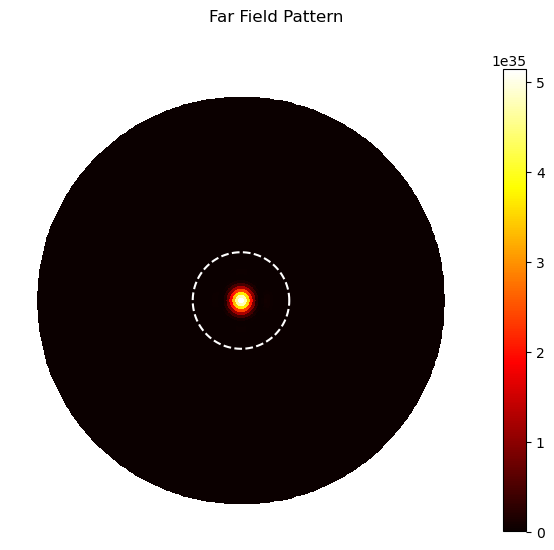

Ex_if shape: (280, 70), Ey_if shape: (280, 70), Ez_if shape: (280, 70)
far_field shape: (280, 70)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
   
# Revised function for plotting far field
def plot_far_field_2D(magnitudes_squared, phi=None, theta=None, ring30=False, ring70=False, save_file=None):
    if phi is None:
        phi = globals()['phi']
    if theta is None:
        theta = globals()['theta']
   
    fig = plt.figure(figsize=(8, 6))
    plt.suptitle(f"Far Field Pattern")
    ax3 = fig.add_subplot(1, 1, 1, polar=True)
 
    im3 = ax3.pcolormesh(phi, theta, magnitudes_squared, cmap="hot")
    fig.colorbar(im3, ax=ax3)
    ax3.grid(False)
    ax3.axis('off')
 
    if ring30:
        ax3.plot(np.linspace(0, 2*np.pi, 100), 1.4*np.ones(100) * np.pi/12, color='w', linestyle='--')
    if ring70:
        ax3.plot(np.linspace(0, 2*np.pi, 100), 1.4*np.ones(100) * np.pi*7/18, color='w', linestyle='--')
   
    if save_file:
        plt.savefig(save_file)
    plt.show()  
 
 
 
#Hexagonal Grid Structure
n_rows =29
n_cols = 29
spacing_if = 0.15e-6
intermediate_distance=2.5e-6
align_if = np.array([.5*spacing_if/2, 0, intermediate_distance])
scattering_centers_if = hexagonal_grid_if(n_rows, n_cols, align_if, spacing_if, intermediate_distance=2.5e-6)
 
 
 
 
# Calculate intermediate field components
intermediate_field, Ex_if, Ey_if, Ez_if = sim.get_intermediate_field(wavelength=wavelength, neglect_Ez=True, return_components=True)
 
 
 
# Step 3: Create an IntermediateField object with the calculated components
intermediate_field_obj = IntermediateField(Ex_if, Ey_if, Ez_if, sim.x_if, sim.y_if)
 
# Step 4: Create the far-field simulation
sim_farfield = DipoleSimulation_farfield(background_index=1, far_distance=.1)
 
# Define scatterers and add to simulationrT
 
scatterers_if = [ScatteringPoint_if(pos, intermediate_distance) for pos in scattering_centers_if]
sim_farfield.add_scatterers_if(scatterers_if)
 
# Calculate and plot the far-field using the intermediate field components directly
far_field = sim_farfield.get_farfield(wavelength=wavelength, Ex_if=Ex_if, Ey_if=Ey_if, Ez_if=Ez_if, neglect_Ez=True)
plot_far_field_2D(far_field, theta=sim_farfield.theta, phi=sim_farfield.phi, ring30=True, ring70=True, save_file="test_far_field")
 
# Debugging output to verify shapes and consistency
print(f"Ex_if shape: {Ex_if.shape}, Ey_if shape: {Ey_if.shape}, Ez_if shape: {Ez_if.shape}")
print(f"far_field shape: {far_field.shape}")
 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Define the plot_collection_by_na function with ring30 and ring70 implementation
def plot_collection_by_na(efficiency, theta, legend=None, color=None, index=1.4, theta_cutoff=-1, linewidth=4, ring30=False, ring70=False, save_file=None):
    """Plots the collection efficiency vs numerical aperture."""
    # Establish the theta values for the x-axis of the plot and adjust them by sin(theta)
    x_values = index * np.sin(theta[:theta_cutoff])
    if color:
        plt.plot(x_values, efficiency[:theta_cutoff], color=color, label=legend, linewidth=linewidth)
    else:
        plt.plot(x_values, efficiency[:theta_cutoff], label=legend, linewidth=linewidth)

    if legend:
        plt.legend(fontsize=12)  # Increase legend font size

    # Add a ring at 30 degrees if ring30 is True
    if ring30:
        ring30_na = index * np.sin(np.deg2rad(30))  # Numerical aperture for 30 degrees
        plt.axvline(x=ring30_na, color='orange', linestyle='--', linewidth=2, label="30° Ring")

    # Add a ring at 70 degrees if ring70 is True
    if ring70:
        ring70_na = index * np.sin(np.deg2rad(70))  # Numerical aperture for 70 degrees
        plt.axvline(x=ring70_na, color='green', linestyle='--', linewidth=2, label="70° Ring")

    # Set axis labels with increased font size
    plt.xlabel("Numerical Aperture", fontsize=16)
    plt.ylabel("Collection Efficiency", fontsize=16)

    # Increase the font size of the ticks
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Add a grid and title
    plt.grid(True)
    plt.title("Collection Efficiency vs Numerical Aperture", fontsize=18)

    # Save the plot if a save_file is specified
    if save_file:
        plt.savefig(save_file)

    # Show the plot
    plt.show()


# Simulate far-field efficiency workflow
# Initialize the far-field simulation
sim_farfield = DipoleSimulation_farfield(background_index=1.4, far_distance=0.1)

# Generate scatterers (example hexagonal grid)
n_rows, n_cols = 25, 25
spacing_if, intermediate_distance = 0.17e-6, 2.5e-6
align_if = np.array([0.5 * spacing_if / 2, 0, intermediate_distance])
scattering_centers_if = hexagonal_grid_if(
    n_rows, n_cols, align_if, spacing_if, intermediate_distance=intermediate_distance
)

# Add scatterers to the simulation
scatterers_if = [ScatteringPoint_if(pos, intermediate_distance) for pos in scattering_centers_if]
sim_farfield.add_scatterers_if(scatterers_if)

# Wavelength for the simulation
wavelength = 649e-9  # Example wavelength in meters

# Step 1: Calculate intermediate field components (Ex_if, Ey_if, Ez_if)
# Assuming `sim` is your intermediate field simulation object
try:
    intermediate_field, Ex_if, Ey_if, Ez_if = sim.get_intermediate_field(
        wavelength=wavelength, neglect_Ez=True, return_components=True
    )
except NameError:
    print("Ensure the intermediate field simulation object (sim) is properly initialized.")
    raise

# Step 2: Compute the far-field using calculated Ex_if, Ey_if, and Ez_if
far_field = sim_farfield.get_farfield(wavelength, Ex_if, Ey_if, Ez_if, neglect_Ez=)

# Optional: Plot the far-field pattern
plot_far_field_2D(far_field, theta=sim_farfield.theta, phi=sim_farfield.phi, ring30=True)

# Step 3: Calculate efficiency
efficiency = sim_farfield.get_efficiency_by_theta(wavelength)

# Step 4: Plot efficiency vs numerical aperture with ring30 and ring70 enabled
theta_values = np.linspace(0, np.pi / 2, sim_farfield.theta_res)  # Adjust theta range
plot_collection_by_na(efficiency, theta_values, color="k", index=1.4, linewidth=4, ring30=True, ring70=False)

# Debugging output
print(f"Efficiency shape: {efficiency.shape}")
print(f"Far-field shape: {far_field.shape}")


SyntaxError: invalid syntax (1734587367.py, line 78)

In [ ]:
def plot_collection_by_na(efficiency, theta, legend=None, color=None, index=1.4, theta_cutoff=-1, linewidth=1):
    """Plots the collection efficiency vs numerical aperture."""
    # Adjust theta values to numerical aperture
    x_values = index * np.sin(theta[:theta_cutoff])
    
    # Plot with optional linewidth
    if color:
        plt.plot(x_values, efficiency[:theta_cutoff], color=color, linewidth=linewidth, label=legend)
    else:
        plt.plot(x_values, efficiency[:theta_cutoff], linewidth=linewidth, label=legend)
    
    # Add legend if provided
    if legend:
        plt.legend()
    
    # Plot a line at 30 degrees for reference
    plt.axvline(x=index * np.sin(30 * np.pi / 180), color='deepskyblue', linestyle='--', linewidth=2)
    
    # Label the axes
    plt.xlabel("Numerical Aperture (n=1.4)")
    plt.ylabel("Collection Efficiency (%)")
    plt.grid(True)
    plt.title("Collection Efficiency vs Numerical Aperture")
    plt.show()


E2 shape: (280, 70)
E2 shape: (280, 70)
Ex_if shape: (280, 70)
Ey_if shape: (280, 70)
Ez_if shape: (280, 70)
x shape: (280, 70)
y shape: (280, 70)
x_if shape: (280, 70)


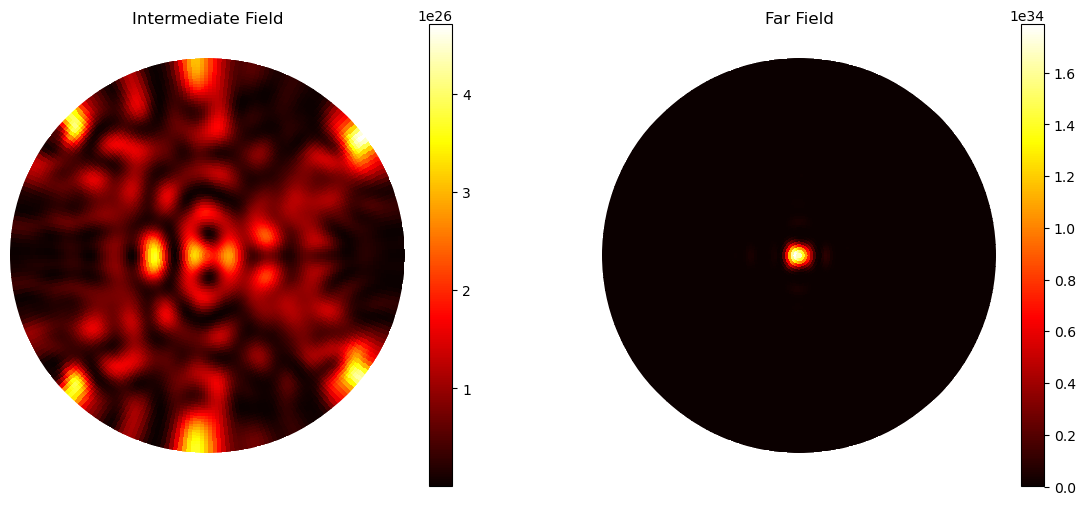

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
 
# Function to plot the intermediate and far fields
def plot_fields(intermediate_field, far_field, theta, phi, title_intermediate="Intermediate Field", title_far="Far Field", save_file=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 6))
   
    # Intermediate field plot
    ax1.set_title(title_intermediate)
    im1 = ax1.pcolormesh(phi, theta, intermediate_field, cmap="hot")
    fig.colorbar(im1, ax=ax1)
    ax1.grid(False)
    ax1.axis('off')
   
    # Far field plot
    ax2.set_title(title_far)
    im2 = ax2.pcolormesh(phi, theta, far_field, cmap="hot")
    fig.colorbar(im2, ax=ax2)
    ax2.grid(False)
    ax2.axis('off')
   
    if save_file:
        plt.savefig(save_file)
   
    plt.show()
 
# Step 1: Load the nearfield data and calculate the intermediate field
nearfield_default = load_nearfield(file_name='matfiles/control_E_nearfield.mat', grid_id='E', x_id='x', y_id='y')
nearfield_default.set_resolution(1000)
 
# Create the intermediate simulation
sim = DipoleSimulation_intermediate(background_index=1.4, intermediate_distance=2.5e-6)
sim.add_nearfield(nearfield_default, "control_nearfield")
 
# Define scatterers and add to simulation
scatterers = [ScatteringPoint(pos) for pos in scattering_centers]
sim.add_scatterers(scatterers)
 
# Calculate intermediate field components
intermediate_field, Ex_if, Ey_if, Ez_if = sim.get_intermediate_field(wavelength=wavelength, neglect_Ez=True, return_components=True)
 
# Step 2: Create the far-field simulation
intermediate_distance=2.5e-6
scatterers_if = [ScatteringPoint_if(pos, intermediate_distance) for pos in scattering_centers_if]
sim_farfield.add_scatterers_if(scatterers_if)
 
# Calculate the far-field using the intermediate field components
far_field = sim_farfield.get_farfield(wavelength=wavelength, Ex_if=Ex_if, Ey_if=Ey_if, Ez_if=Ez_if, neglect_Ez=True)
 
# Plot the fields side by side for comparison
plot_fields(intermediate_field, far_field, theta=sim.theta, phi=sim.phi, save_file="fields_comparison.png")
 
 
 

In [ ]:
import numpy as np
import h5py
from scipy.interpolate import griddata
from matplotlib import pyplot as plt
 
# Function to calculate power
def calculate_power(field_intensity, theta, phi):
    # Step 1: Calculate dtheta and dphi
    dtheta = np.abs(theta[1, 0] - theta[0, 0])
    dphi = np.abs(phi[0, 1] - phi[0, 0])
 
 
    # Manually set dtheta and dphi if they are zero or calculated incorrectly
    if dtheta == 0 or dphi == 0:
        dtheta = np.pi / theta.shape[0]
        dphi = 2 * np.pi / theta.shape[1]
 
 
    # Step 2: Calculate the differential area
    differential_area = np.sin(theta) * dtheta * dphi
    #print("Differential Area Sample (first 10 values):", differential_area.flatten()[0:10])
 
    # Step 3: Calculate power
    power = np.sum(field_intensity * differential_area)
    return power
 
# Function to plot the intermediate and far fields
def plot_fields(intermediate_field, far_field, theta, phi, title_intermediate="Intermediate Field", title_far="Far Field", save_file=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 6))
   
    # Intermediate field plot
    ax1.set_title(title_intermediate)
    im1 = ax1.pcolormesh(phi, theta, intermediate_field, cmap="hot")
    fig.colorbar(im1, ax=ax1)
    ax1.grid(False)
    ax1.axis('off')
   
    # Far field plot
    ax2.set_title(title_far)
    im2 = ax2.pcolormesh(phi, theta, far_field, cmap="hot")
    fig.colorbar(im2, ax=ax2)
    ax2.grid(False)
    ax2.axis('off')
   
    if save_file:
        plt.savefig(save_file)
   
    plt.show()
 
# Assuming the other classes and functions are already defined...
 
# Step 1: Load the nearfield data and calculate the intermediate field
nearfield_default = load_nearfield(file_name='matfiles/control_E_nearfield.mat', grid_id='E', x_id='x', y_id='y')
nearfield_default.set_resolution(1000)
 
# Create the intermediate simulation
sim = DipoleSimulation_intermediate(background_index=1.4, intermediate_distance=2.5e-6)
sim.add_nearfield(nearfield_default, "control_nearfield")
 
# Define scatterers and add to simulation
scatterers = [ScatteringPoint(pos) for pos in scattering_centers]
sim.add_scatterers(scatterers)
 
# Calculate intermediate field components
intermediate_field, Ex_if, Ey_if, Ez_if = sim.get_intermediate_field(wavelength=wavelength, neglect_Ez=True, return_components=True)
Intermediate_intensity = intermediate_field/(2*377)
 
# Step 2: Create the far-field simulation
sim_farfield = DipoleSimulation_farfield(background_index=1.4, far_distance=.1)
sim_farfield.add_scatterers_if(scatterers_if)
 
# Calculate the far-field using the intermediate field components
far_field = sim_farfield.get_farfield(wavelength=wavelength, Ex_if=Ex_if, Ey_if=Ey_if, Ez_if=Ez_if, neglect_Ez=True)
far_field_intensity = far_field/(2*377)
 
 
 
 
 
# Step 4: Calculate the power for intermediate and far fields
intermediate_power = calculate_power(Intermediate_intensity, theta=sim.theta, phi=sim.phi)
print(f"Intermediate Field Power: {intermediate_power:.4e} W")
 
far_field_power = calculate_power(far_field_intensity, theta=sim.theta, phi=sim.phi)
print(f"Far Field Power: {far_field_power:.4e} W")
 

E2 shape: (280, 70)
E2 shape: (280, 70)
Ex_if shape: (280, 70)
Ey_if shape: (280, 70)
Ez_if shape: (280, 70)
x shape: (280, 70)
y shape: (280, 70)
x_if shape: (280, 70)
Intermediate Field Power: 1.1950e+24 W
Far Field Power: 2.2271e+29 W
